In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Kkma, Hannanum, Okt, Komoran
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
dataset = pd.read_csv('dataset/dataset.csv', encoding="utf-8")
dataset.head()

,document_id,text,label
0,2,"""갑""과 ""을""은 본 공사를 원활하게 수행하기 위하여 상호 신의성실의 원칙에 따라 ...",1
1,2,"공사목적물은 견적서에 의거하여 시공하는 건축물로 하며'' 설계변경 등 '갑""과 ""을...",2
2,2,도급금액은 원칙적으로 본 계약상의 도급금액으로 한다'',4
3,2,"다음 각 호 1의 사유로 ""을""의 제반 비용이 발생할 경우 도급금액을 변경 한다''",4
4,2,"제 2 항에 의한 도급금액의 변경은 ""을""이 변경 내역을 작성하여 ""갑"" 에게 요청...",4


In [3]:
dataset['text'].nunique(), dataset['label'].nunique()

(600, 21)

In [4]:
dataset.isnull().values.any()

False

In [5]:
# stratify 옵션이 안먹는 이유: 1개만 존재하는 클래스가 있음, 최소 2개 이상은 있어야 가능
from sklearn.utils import shuffle

train_data = shuffle(dataset, random_state=42)

In [6]:
train_data.head()

,document_id,text,label
634,50,"""을""은 제2항의 규정에 의한 통지를 받은 때에는 다음의 사항을 준수하여야 한다.",8
220,27,"명백한 ""A"" 실책에 의한 공사지연으로 약정된 공사가 오픈이 지연될 시 ""A""은 ""...",7
426,41,"공사 시설물에 대한 일체의 권한은 공사완공까지 ""을""이 가지며 잔금 지불 후 ""갑""...",0
428,41,"""을""이 공사를 진행하는 중 ""갑""의 자재변경이나 수정 또는 재공사로 인한 초과금액...",11
72,5,"""시공업자""는 공사 완료 후 무상 수리 기간을 12개월로 한다. ( 천재지변 및 시...",13


In [7]:
print("훈련용 데이터 수: ", len(train_data))

훈련용 데이터 수:  647


### 훈련 데이터 셋의 분포

<AxesSubplot:>

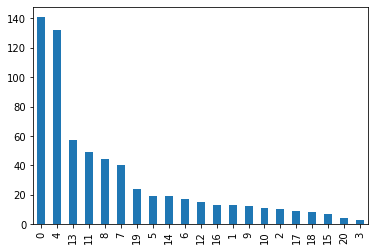

In [8]:
train_data['label'].value_counts().plot(kind='bar')

In [9]:
print(train_data.groupby('label').size().reset_index(name = 'count').sort_values(by='count', ascending=False))

    label  count
0       0    141
4       4    132
13     13     57
11     11     49
8       8     44
7       7     40
19     19     24
14     14     19
5       5     19
6       6     17
12     12     15
16     16     13
1       1     13
9       9     12
10     10     11
2       2     10
17     17      9
18     18      8
15     15      7
20     20      4
3       3      3


In [10]:
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ")
train_data['text'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

document_id    0
text           0
label          0
dtype: int64


C:\Users\kimseungmun\AppData\Local\Temp/ipykernel_18816/4029668336.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ")


In [11]:
# test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ")
# test_data['text'].replace('', np.nan, inplace=True)
# print('전처리 후 테스트용 샘플 수: ', len(test_data))

In [12]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', 
             '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임',
            '만', '겜', '되', '음', '면', '제', '항', '저', '및', '으로', '어',
            '등', '이나', '또는', '보', 'ㄴ', '어서', '늘', '모든', '대', '에서', '갑']

In [13]:
hannanum = Hannanum()

train_data['tokenized'] = train_data['text'].apply(hannanum.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# test_data['tokenized'] = test_data['text'].apply(hannanum.morphs)
# test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [14]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
# X_test = test_data['tokenized'].values
# y_test = test_data['label'].values

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [16]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_cnt += 1
        rare_freq += value
        
print("단어 집합 크기: ", total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수: %s"%(threshold-1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율: ", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: ", (rare_freq / total_freq)*100)

단어 집합 크기:  1633
등장 빈도가 1번 이하인 희귀 단어의 수: 791
단어 집합에서 희귀 단어의 비율:  48.438456827924064
전체 등장 빈도에서 희귀 단어 등장 빈도 비율:  6.6498528793610765


In [17]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기: ', vocab_size)

단어 집합의 크기:  844


In [18]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
print(X_train[:3])
# print(X_test[:3])

[[37, 30, 13, 57, 73, 14, 10, 35, 53, 194, 7, 2], [1, 1, 13, 502, 503, 4, 1, 45, 3, 55, 9, 209, 68, 28, 3, 6, 260, 103, 341, 19, 504, 1, 40, 2], [4, 114, 31, 100, 171, 261, 115, 229, 15, 123, 40, 18, 9, 181, 2]]


최대 길이:  79
평균 길이:  18.38485316846986


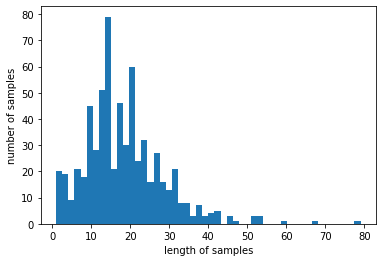

In [20]:
print('최대 길이: ', max(len(l) for l in X_train))
print('평균 길이: ', sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if (len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count/len(nested_list))*100))

In [22]:
max_len = 35
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 35 이하인 샘플의 비율: 94.5904173106646


In [23]:
X_train = pad_sequences(X_train, max_len, padding='post')
# X_test = pad_sequences(X_test, max_len)

In [24]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
embedding_dim = 300
hidden_units = 42

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=35))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(21, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 300)           253200    
_________________________________________________________________
bidirectional (Bidirectional (None, 84)                115248    
_________________________________________________________________
dense (Dense)                (None, 21)                1785      
Total params: 370,233
Trainable params: 370,233
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [28]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)

In [29]:
history = model.fit(X_train, y_train, epochs=20, batch_size=10)

Epoch 1/20
65/65 [==============================] - 4s 12ms/step - loss: 0.2912 - acc: 0.1747
Epoch 2/20
65/65 [==============================] - 1s 14ms/step - loss: 0.1645 - acc: 0.2473
Epoch 3/20
65/65 [==============================] - 1s 12ms/step - loss: 0.1598 - acc: 0.3447
Epoch 4/20
65/65 [==============================] - 1s 12ms/step - loss: 0.1512 - acc: 0.3895
Epoch 5/20
65/65 [==============================] - 1s 13ms/step - loss: 0.1408 - acc: 0.4127
Epoch 6/20
65/65 [==============================] - 1s 12ms/step - loss: 0.1266 - acc: 0.5332
Epoch 7/20
65/65 [==============================] - 1s 11ms/step - loss: 0.1139 - acc: 0.5920
Epoch 8/20
65/65 [==============================] - 1s 11ms/step - loss: 0.1018 - acc: 0.6491
Epoch 9/20
65/65 [==============================] - 1s 11ms/step - loss: 0.0898 - acc: 0.7233
Epoch 10/20
65/65 [==============================] - 1s 11ms/step - loss: 0.0790 - acc: 0.7774
Epoch 11/20
65/65 [==============================] - 1s 11m

In [30]:
# y_test_origin = y_test
# y_test = to_categorical(y_test, num_classes=21)

In [31]:
# model.evaluate(X_test, y_test)

In [32]:
def predict_test(new_sentence):
    new_sentence = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ", new_sentence)
    new_sentence = hannanum.morphs(new_sentence)
    new_sentence = [ word for word in new_sentence if not word in stopwords ]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen=max_len, padding='post')
    score = model.predict(pad_new)
    
    return np.argmax(score[0])

In [33]:
standard = pd.read_csv('dataset/standard.csv', names=['document_id', 'text', 'label'], encoding="utf-8")
result = []
model_predict = []
for doc_id, text, label in standard.values:
    print("실제 조항 번호: ", label)
    predict = predict_test(text)
    model_predict.append(predict)
    print("모델 조항 번호: ", predict)
    if label == predict:
        result.append(True)
    else:
        result.append(False)
    print("================================")
    
print(sum(result)/len(result))

model_predict.sort()
print(set(model_predict))

실제 조항 번호:  1
모델 조항 번호:  1
실제 조항 번호:  2
모델 조항 번호:  2
실제 조항 번호:  2
모델 조항 번호:  11
실제 조항 번호:  2
모델 조항 번호:  14
실제 조항 번호:  3
모델 조항 번호:  6
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  2
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  5
모델 조항 번호:  5
실제 조항 번호:  5
모델 조항 번호:  5
실제 조항 번호:  5
모델 조항 번호:  13
실제 조항 번호:  6
모델 조항 번호:  6
실제 조항 번호:  6
모델 조항 번호:  13
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  9
모델 조항 번호:  9
실제 조항 번호:  9
모델 조항 번호:  9
실제 조항 번호:  10
모델 조항 번호:  11
실제 조항 번호:  10
모델 조항 번호:  10
실제 조항 번호:  10
모델 조항 번호:  10
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  12
모델 조항 번호:  4
실제 조항 번호:  12
모델 조항 번호:  12
실제 조항 번호:  12
모델 조항 번호:  19
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  13
모델 조항 번호:  7
실제 조항 번호:  14
모델 조항 번호:  14
실제 조항 번호:  14
모델 조항 번호:  14
실제 조항 

In [34]:
standard = pd.read_csv('dataset/part1.csv', names=['document_id', 'text', 'label'], encoding="utf-8")
result = []
model_predict = []
for doc_id, text, label in standard.values:
    print("실제 조항 번호: ", label)
    predict = predict_test(text)
    model_predict.append(predict)
    print("모델 조항 번호: ", predict)
    if label == predict:
        result.append(True)
    else:
        result.append(False)
    print("================================")
    
print(sum(result)/len(result))

model_predict.sort()
print(set(model_predict))

실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  7
모델 조항 번호:  0
실제 조항 번호:  4
모델 조항 번호:  0
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  12
모델 조항 번호:  12
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  7
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  19
모델 조항 번호:  19
실제 조항 번호:  19
모델 조항 번호:  19
0.9090909090909091
{0, 4, 7, 8, 11, 12, 13, 19}


In [35]:
standard = pd.read_csv('dataset/part2.csv', names=['document_id', 'text', 'label'], encoding="utf-8")
result = []
model_predict = []
for doc_id, text, label in standard.values:
    print("실제 조항 번호: ", label)
    predict = predict_test(text)
    model_predict.append(predict)
    print("모델 조항 번호: ", predict)
    if label == predict:
        result.append(True)
    else:
        result.append(False)
    print("================================")
    
print(sum(result)/len(result))

model_predict.sort()
print(set(model_predict))

실제 조항 번호:  1
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  7
모델 조항 번호:  5
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  7
모델 조항 번호:  4
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  12
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  19
모델 조항 번호:  19
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
0.84
{0, 4, 5, 7, 8, 11, 13, 19}


In [36]:
standard = pd.read_csv('dataset/part3.csv', names=['document_id', 'text', 'label'], encoding="utf-8")
result = []
model_predict = []
for doc_id, text, label in standard.values:
    print("실제 조항 번호: ", label)
    predict = predict_test(text)
    model_predict.append(predict)
    print("모델 조항 번호: ", predict)
    if label == predict:
        result.append(True)
    else:
        result.append(False)
    print("================================")
    
print(sum(result)/len(result))

model_predict.sort()
print(set(model_predict))

실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  11
모델 조항 번호:  4
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  12
모델 조항 번호:  12
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  7
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  19
모델 조항 번호:  19
실제 조항 번호:  19
모델 조항 번호:  19
0.9230769230769231
{0, 4, 7, 8, 11, 12, 13, 19}


In [37]:
standard = pd.read_csv('dataset/part4.csv', names=['document_id', 'text', 'label'], encoding="utf-8")
result = []
model_predict = []
for doc_id, text, label in standard.values:
    print("실제 조항 번호: ", label)
    predict = predict_test(text)
    model_predict.append(predict)
    print("모델 조항 번호: ", predict)
    if label == predict:
        result.append(True)
    else:
        result.append(False)
    print("================================")
    
print(sum(result)/len(result))

model_predict.sort()
print(set(model_predict))

실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  1
모델 조항 번호:  1
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  11
모델 조항 번호:  7
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  7
모델 조항 번호:  4
실제 조항 번호:  0
모델 조항 번호:  4
실제 조항 번호:  6
모델 조항 번호:  6
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  7
모델 조항 번호:  7
실제 조항 번호:  0
모델 조항 번호:  7
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  19
모델 조항 번호:  19
실제 조항 번호:  19
모델 조항 번호:  19
실제 조항 번호:  13
모델 조항 번호:  13
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  11
모델 조항 번호:  11
실제 조항 번호:  4
모델 조항 번호:  6
실제 조항 번호:  7
모델 조항 번호:  4
실제 조항 번호:  11
모델 조항 번호:  7
0.6956521739130435
{0, 1, 4, 6, 7, 8, 11, 13, 19}


In [38]:
standard = pd.read_csv('dataset/part5.csv', names=['document_id', 'text', 'label'], encoding="utf-8")
result = []
model_predict = []
for doc_id, text, label in standard.values:
    print("실제 조항 번호: ", label)
    predict = predict_test(text)
    model_predict.append(predict)
    print("모델 조항 번호: ", predict)
    if label == predict:
        result.append(True)
    else:
        result.append(False)
    print("================================")
    
print(sum(result)/len(result))

model_predict.sort()
print(set(model_predict))

실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  7
실제 조항 번호:  13
모델 조항 번호:  0
실제 조항 번호:  4
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  13
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  0
실제 조항 번호:  4
모델 조항 번호:  6
실제 조항 번호:  19
모델 조항 번호:  0
실제 조항 번호:  2
모델 조항 번호:  14
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  1
모델 조항 번호:  19
실제 조항 번호:  0
모델 조항 번호:  13
실제 조항 번호:  0
모델 조항 번호:  8
0.3888888888888889
{0, 4, 6, 7, 8, 13, 14, 19}


In [39]:
standard = pd.read_csv('dataset/part6_1.csv', names=['document_id', 'text', 'label'], encoding="utf-8")
result = []
model_predict = []
for doc_id, text, label in standard.values:
    print("실제 조항 번호: ", label)
    predict = predict_test(text)
    model_predict.append(predict)
    print("모델 조항 번호: ", predict)
    if label == predict:
        result.append(True)
    else:
        result.append(False)
    print("================================")
    
print(sum(result)/len(result))

model_predict.sort()
print(set(model_predict))

실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  0
실제 조항 번호:  4
모델 조항 번호:  13
실제 조항 번호:  13
모델 조항 번호:  4
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  1
모델 조항 번호:  1
실제 조항 번호:  0
모델 조항 번호:  4
실제 조항 번호:  0
모델 조항 번호:  4
실제 조항 번호:  0
모델 조항 번호:  4
실제 조항 번호:  0
모델 조항 번호:  4
실제 조항 번호:  0
모델 조항 번호:  4
실제 조항 번호:  0
모델 조항 번호:  6
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  4
실제 조항 번호:  2
모델 조항 번호:  2
실제 조항 번호:  2
모델 조항 번호:  0
실제 조항 번호:  4
모델 조항 번호:  0
실제 조항 번호:  4
모델 조항 번호:  0
실제 조항 번호:  4
모델 조항 번호:  7
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  8
모델 조항 번호:  8
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  0
모델 조항 번호:  0
실제 조항 번호:  9
모델 조항 번호:  13
실제 조항 번호:  9
모델 조항 번호:  9
실제 조항 번호:  2
모델 조항 번호:  4
실제 조항 번호:  2
모델 조항 번호:  0
실제 조항 번호:  2
모델 조항 번호:  8
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  4
실제 조항 번호:  4
모델 조항 번호:  11
실제 조항 번호